In [213]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_csv('Sample - Superstore.csv', encoding='ISO-8859-1')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df.shape

(9994, 21)

In [4]:
df.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State',
       'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category',
       'Product Name', 'Sales', 'Quantity', 'Discount', 'Profit'],
      dtype='object')

In [5]:
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [6]:
catt = df.groupby('Category').size().reset_index(name='Count')
catt

,Category,Count
0,Furniture,2121
1,Office Supplies,6026
2,Technology,1847


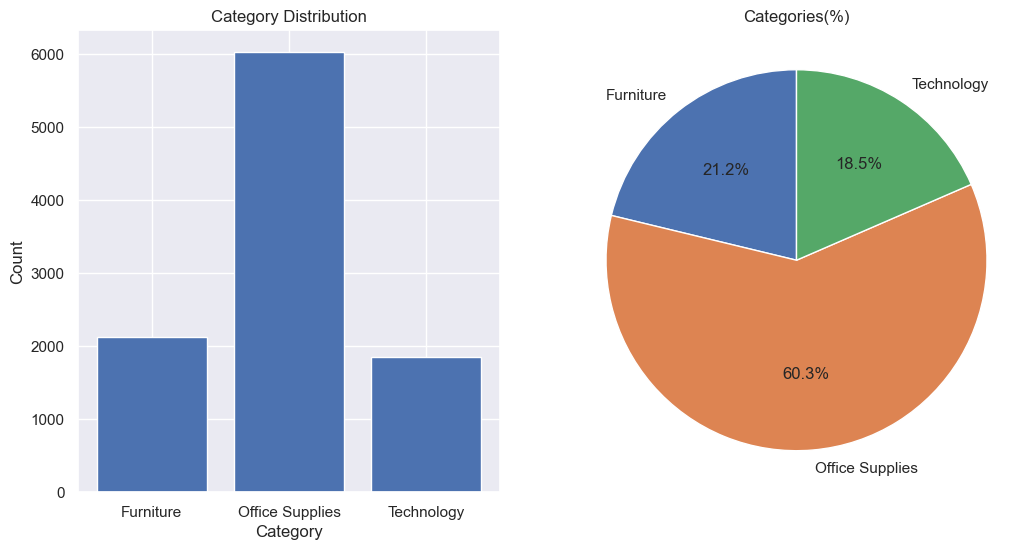

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))
ax[0].bar(catt['Category'], catt['Count'])
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Count')
ax[0].set_title('Category Distribution')

ax[1].pie(catt['Count'], labels=catt['Category'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Categories(%)')
plt.show()

- Majority of the goods in our Store are Office Supplies(makes up around 60% of the goods), while Furniture and Technology make up 21.2% and 18.5% respectively

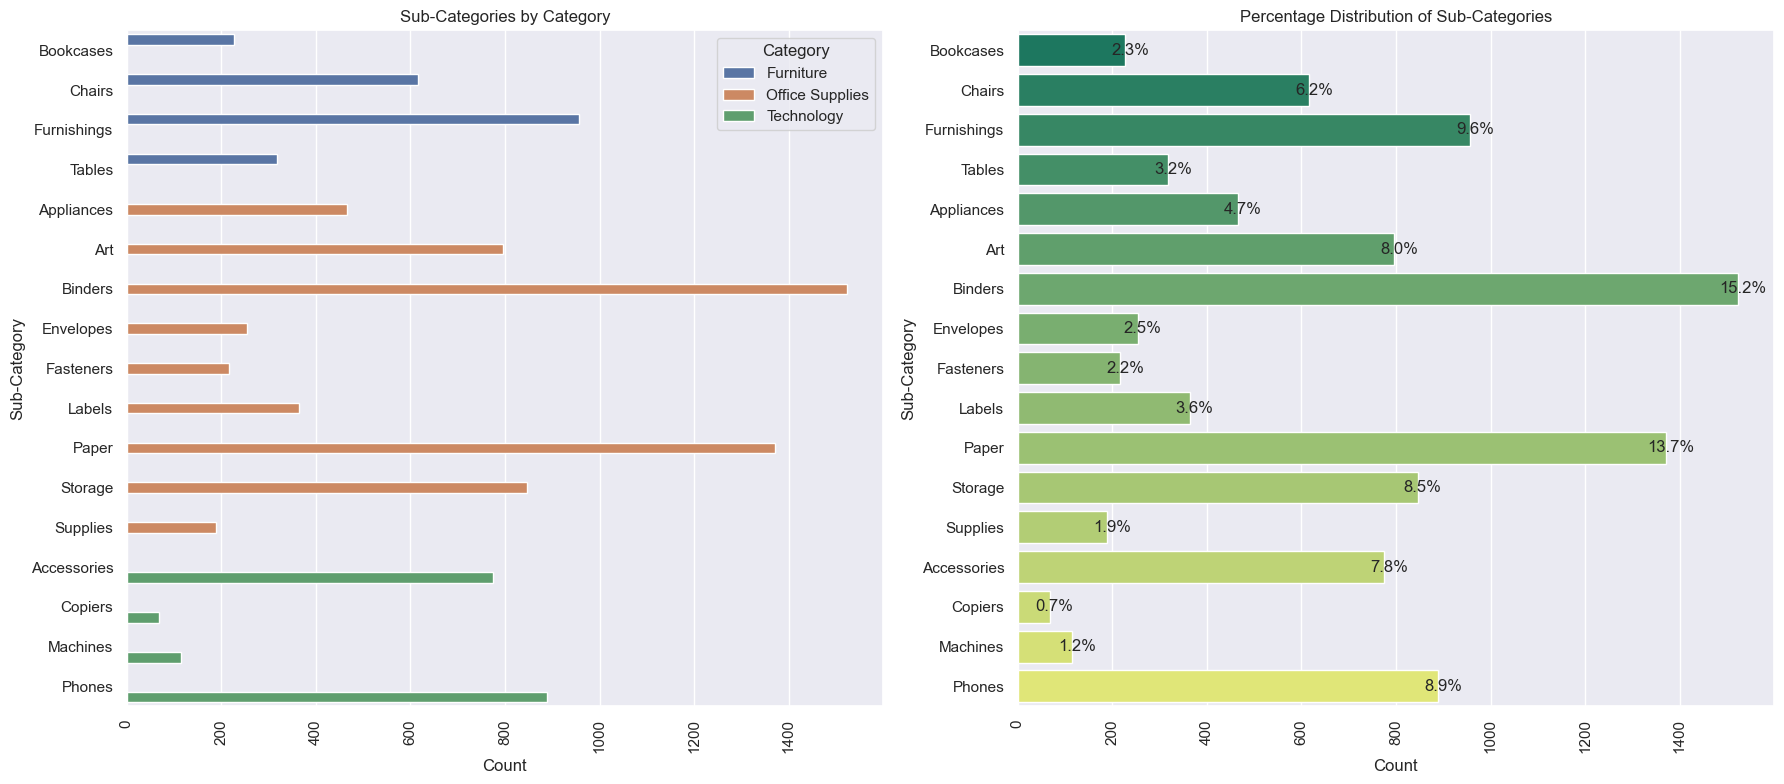

In [8]:
categories = df.groupby(['Category', 'Sub-Category']).size().reset_index(name='Count')

fig, ax = plt.subplots(1, 2, figsize=(18,8))

sns.barplot(x='Count', y='Sub-Category', hue='Category', ax=ax[0], data=categories)
sns.barplot(x='Count', y='Sub-Category', data=categories, ax=ax[1], palette='summer')

total = float(len(df))
for p in ax[1].patches:
    width = p.get_width()
    plt.text(width + 10, p.get_y() + p.get_height() / 2, f'{width/total*100:.1f}%', ha='center', va='center')

ax[0].set_title('Sub-Categories by Category')
ax[0].set_xlabel('Count')
ax[0].set_ylabel('Sub-Category')
ax[0].tick_params(axis='x', rotation=90)

ax[1].set_title('Percentage Distribution of Sub-Categories')
ax[1].set_xlabel('Count')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

- For each Category of goods, we have Sub-categories, of which Binders(15.2%), Paper(13.7%) and Furnishings(9.6%) make up for the majority of goods in stock. Others are Phone, Storage, Art, Accessories etc., in order of decreasing quantity of goods.

In [9]:
sales = df.groupby(['Sales','Category','Sub-Category','Profit', 'Discount', 'Quantity']).size().reset_index(name='Count')
sell = sales[['Discount', 'Profit']].sort_values('Profit')
sell

,Discount,Profit
7701,0.7,-6599.9780
7716,0.5,-3839.9904
7609,0.8,-3701.8928
7637,0.7,-3399.9800
7577,0.8,-2929.4845
...,...,...
7722,0.0,4630.4755
7723,0.0,4946.3700
7724,0.0,5039.9856
7726,0.0,6719.9808


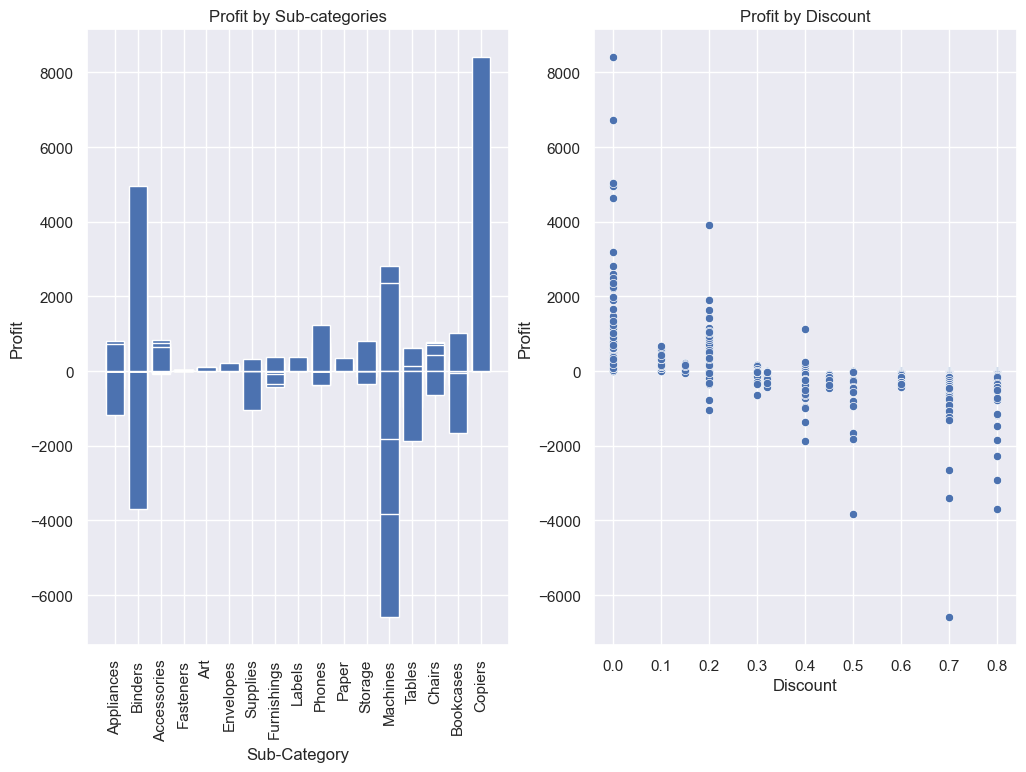

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].bar(sales['Sub-Category'], sales['Profit'])
ax[0].set_xlabel('Sub-Category')
ax[0].set_ylabel('Profit')
ax[0].set_title('Profit by Sub-categories')
ax[0].tick_params(axis='x', rotation=90)

sns.scatterplot(x='Discount', y='Profit', ax=ax[1], data=sales)
ax[1].set_xlabel('Discount')
ax[1].set_ylabel('Profit')
ax[1].set_title('Profit by Discount')

plt.show()

- From the graph above, we recorded some losses for some sub-categories(negative profits), with Machines taking the most hit, followed by Tables, Supplies, Bookcases and Appliances. For the other Sub-categories, we recorded positive profits, with the most profit coming from Coppiers.
- Overall, we recorded a net profit of 229,102.


- These losses, as we can see from the graph on the right stern from the discount in sales.

## Average Profit for Category and Sub-category

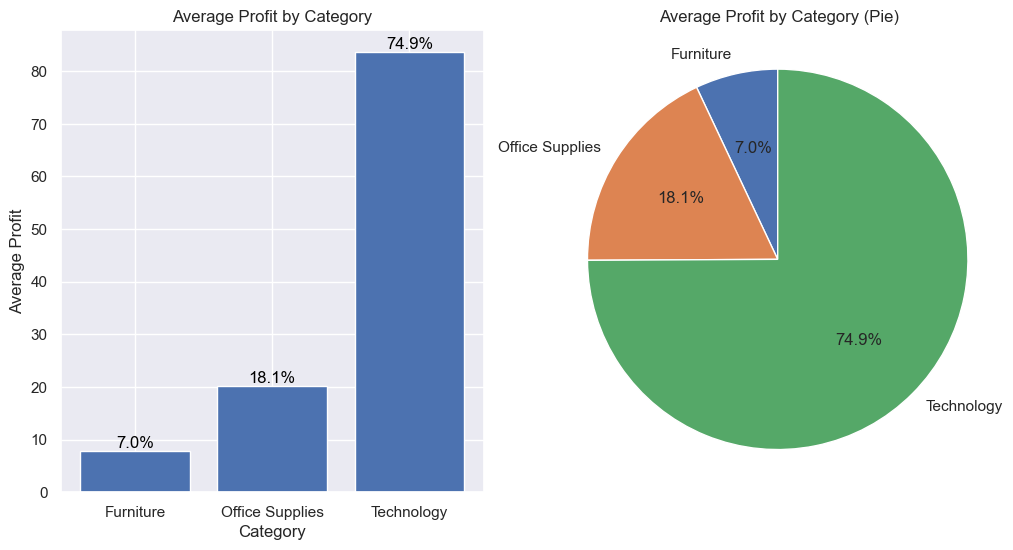

In [11]:
avg_profit = sales.groupby('Category')['Profit'].mean().reset_index(name='Average Profit')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_profit['Category'], avg_profit['Average Profit'])

total = abs(avg_profit['Average Profit'].sum())
for i, value in enumerate(avg_profit['Average Profit']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')
    
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Average Profit')
ax[0].set_title('Average Profit by Category')

ax[1].pie(avg_profit['Average Profit'], labels=avg_profit['Category'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Profit by Category (Pie)')

plt.show()

- Most of the profits made in store are from goods in Techn category, making for about 75% of the stores profits (the sale of Copiers contributed immensely), with goods in categories, Office supplies and Furniture making up for the remaining 25% of profit (18% and 7% respectively).

In [41]:
tech = df[df['Category'] == 'Technology']
furn = df[df['Category'] == 'Furniture']
os = df[df['Category'] == 'Office Supplies']

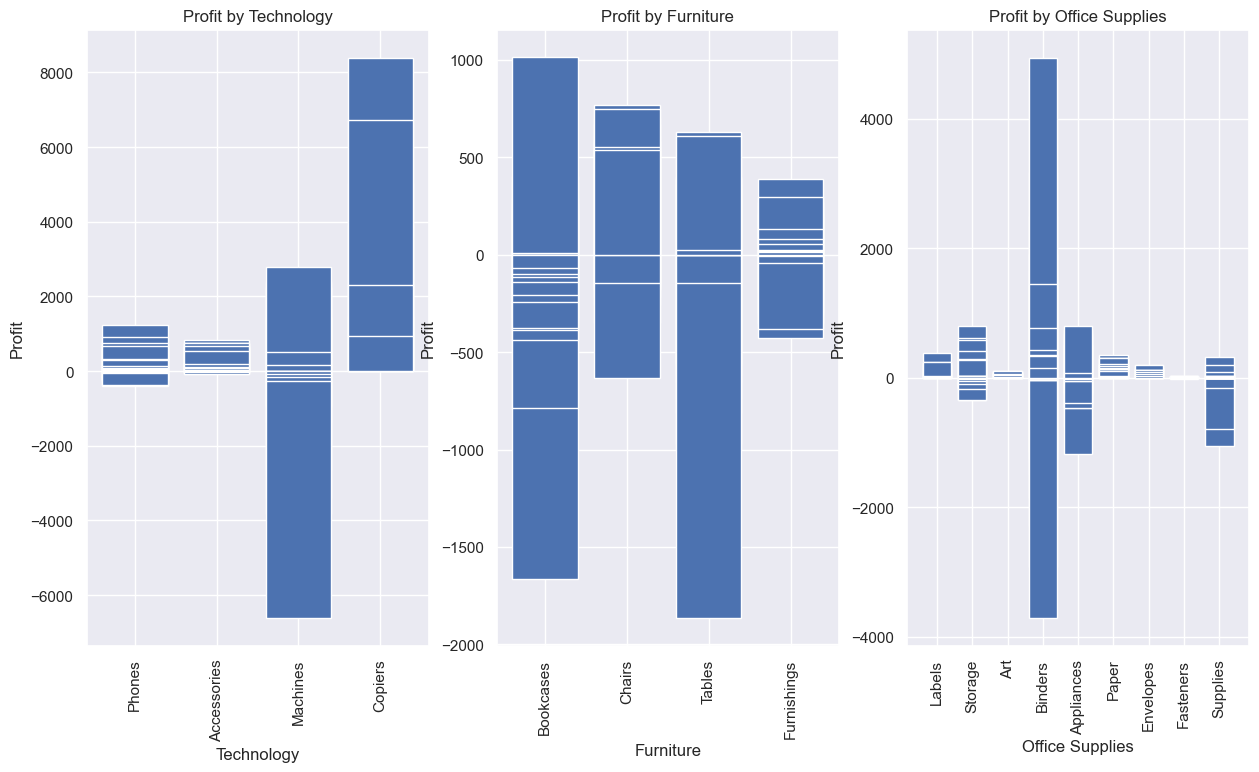

In [51]:
tech_profit = tech[['Sub-Category', 'Profit']]
furn_profit = furn[['Sub-Category', 'Profit']]
os_profit = os[['Sub-Category', 'Profit']]

fig, ax = plt.subplots(1, 3, figsize=(15,8))

ax[0].bar(tech_profit['Sub-Category'], tech_profit['Profit'])
ax[0].set_xlabel('Technology')
ax[0].set_ylabel('Profit')
ax[0].set_title('Profit by Technology')
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(furn_profit['Sub-Category'], furn_profit['Profit'])
ax[1].set_xlabel('Furniture')
ax[1].set_ylabel('Profit')
ax[1].set_title('Profit by Furniture')
ax[1].tick_params(axis='x', rotation=90)

ax[2].bar(os_profit['Sub-Category'], os_profit['Profit'])
ax[2].set_xlabel('Office Supplies')
ax[2].set_ylabel('Profit')
ax[2].set_title('Profit by Office Supplies')
ax[2].tick_params(axis='x', rotation=90)

plt.show()

- Technology: for the sub-categories under Technology, most of the profit was made from the sale of Topiers, Phones and Accessories also generated profit for the store, while Machines on the other hand has a net loss, these losses recorded for both Machines and Phones(less conspicuos) are most likely due to the rate of discount offered on sale for these products.


- Furniture: most losses recorded in the store comes from this category, as all of the products are sold at a high discount. only about 7% of the stores average profit comes from this category


- Office Supplies: about 18% of the stores average profit comes from this category, and this poor performance comes from the discounted sales of the products under this category. take for example; binders and supplies are the most sold products in this category and binders happens to be sold at an 80% discount along side appliances, while Supplies sold at a 20% discount.

## Average Sales for Category and Sub-Category

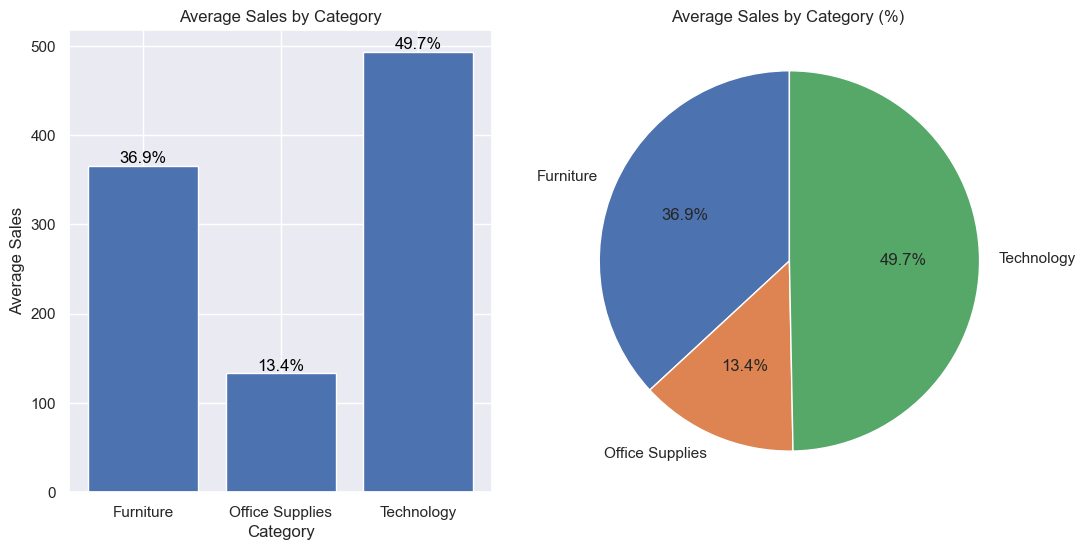

In [12]:
avg_sales = sales.groupby('Category')['Sales'].mean().reset_index(name='Average Sales')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_sales['Category'], avg_sales['Average Sales'])

total = abs(avg_sales['Average Sales'].sum())
for i, value in enumerate(avg_sales['Average Sales']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')

ax[0].set_xlabel('Category')
ax[0].set_ylabel('Average Sales')
ax[0].set_title('Average Sales by Category')

ax[1].pie(avg_sales['Average Sales'], labels=avg_sales['Category'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Sales by Category (%)')

plt.show()

- Most of the stores sales(about 50%) fall under Technology, with Furniture making up for about 37% of sales and Office Supplies, being the lowest selling category makes up for the remaining 13% 

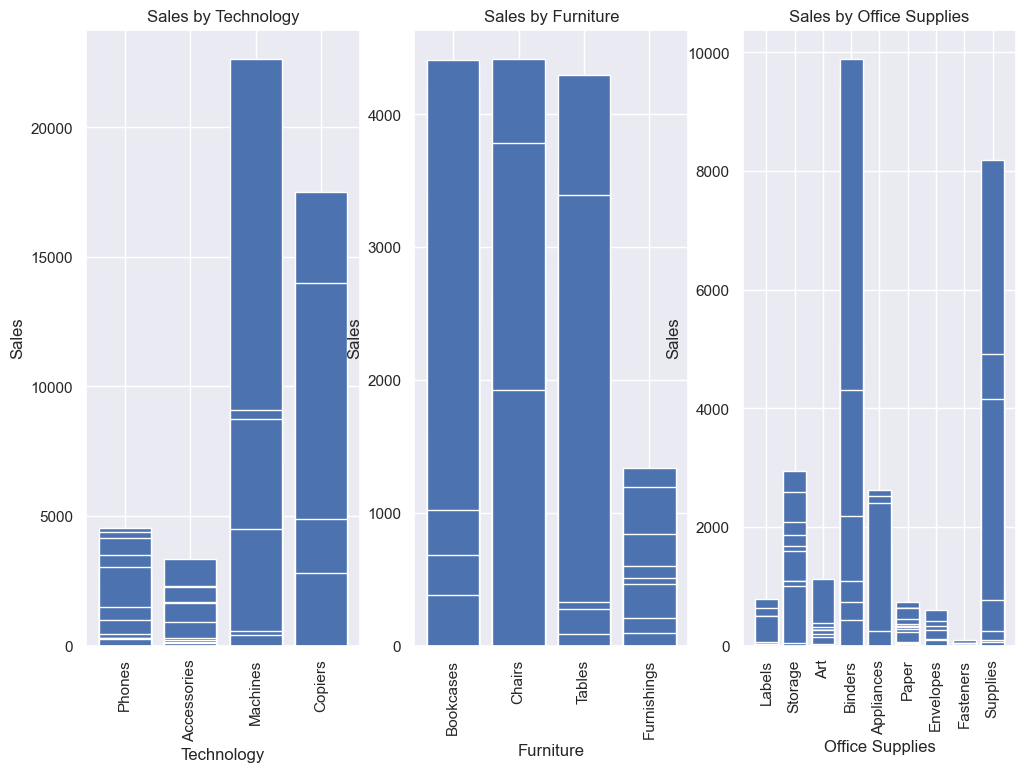

In [48]:
tech_sales = tech[['Sub-Category', 'Sales']]
furn_sales = furn[['Sub-Category', 'Sales']]
os_sales = os[['Sub-Category', 'Sales']]

fig, ax = plt.subplots(1, 3, figsize=(12, 8))

ax[0].bar(tech_sales['Sub-Category'], tech_sales['Sales'])
ax[0].set_xlabel('Technology')
ax[0].set_ylabel('Sales')
ax[0].set_title('Sales by Technology')
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(furn_sales['Sub-Category'], furn_sales['Sales'])
ax[1].set_xlabel('Furniture')
ax[1].set_ylabel('Sales')
ax[1].set_title('Sales by Furniture')
ax[1].tick_params(axis='x', rotation=90)

ax[2].bar(os_sales['Sub-Category'], os_sales['Sales'])
ax[2].set_xlabel('Office Supplies')
ax[2].set_ylabel('Sales')
ax[2].set_title('Sales by Office Supplies')
ax[2].tick_params(axis='x', rotation=90)

plt.show()

- Technology: being the category with most sales, two products(Machines and Copies) contributed immensely to the number of sales


- Furniture: furniture also recorded some high selling products, with Furnishing making the least sales in this category


- Office supplies: this category didn't really do well in term of sales, however, two products sstood out; Binders and Supplies.

## Average Discount for Category and Sub-Category

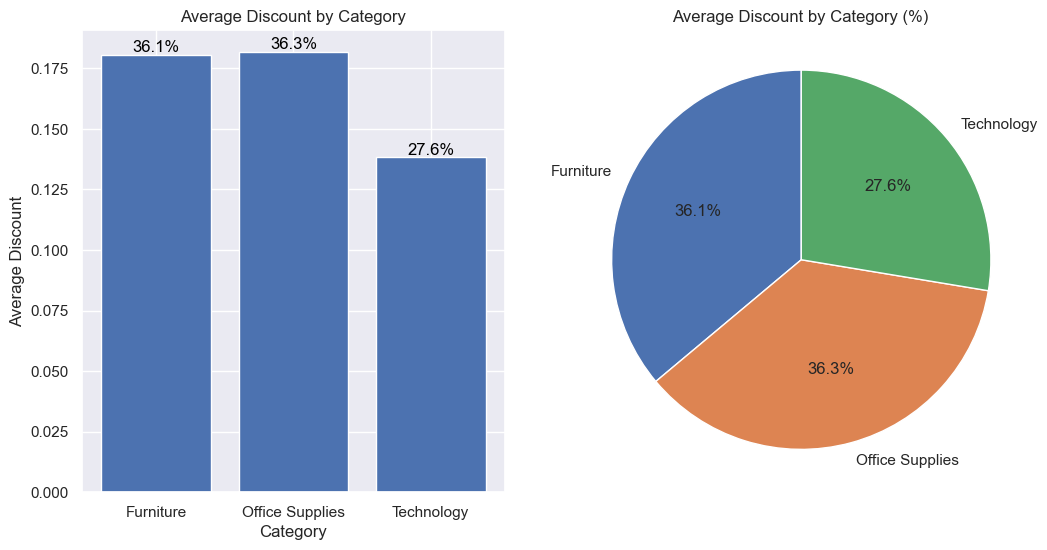

In [13]:
avg_discount = sales.groupby('Category')['Discount'].mean().reset_index(name='Average Discount')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_discount['Category'], avg_discount['Average Discount'])

total = abs(avg_discount['Average Discount'].sum())
for i, value in enumerate(avg_discount['Average Discount']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')

ax[0].set_xlabel('Category')
ax[0].set_ylabel('Average Discount')
ax[0].set_title('Average Discount by Category')

ax[1].pie(avg_discount['Average Discount'], labels=avg_discount['Category'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Discount by Category (%)')

plt.show()

- All the category of products in our store offers around 30% discount each, this alone is enough to pull down our profits on sales by a wide margin

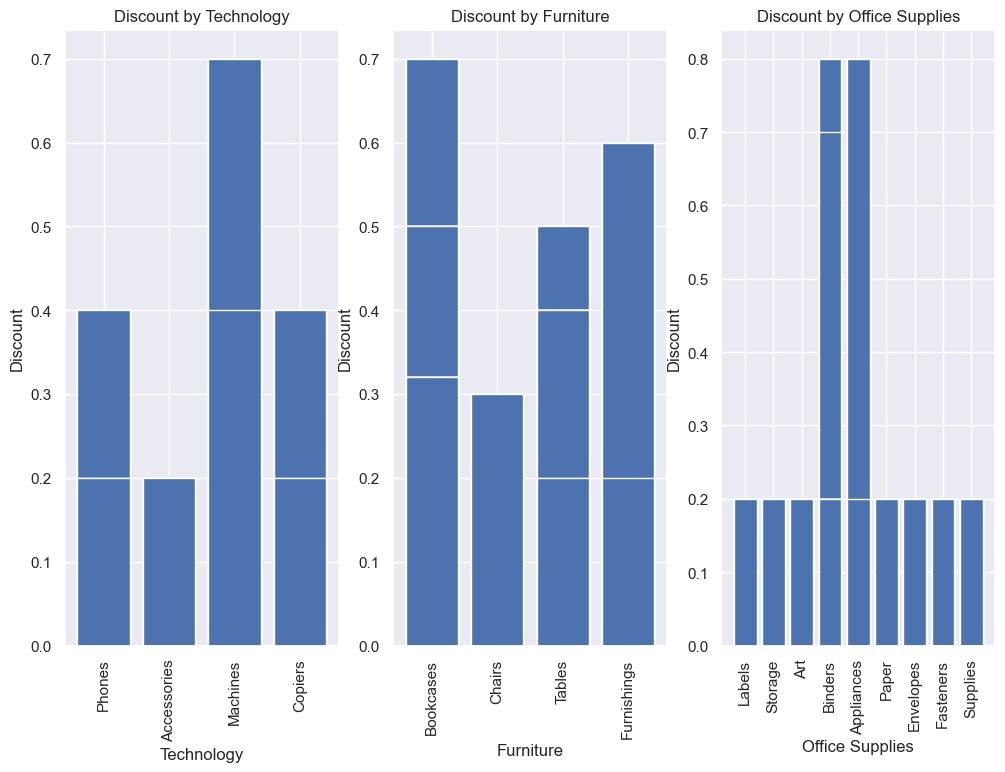

In [49]:
tech_discount = tech[['Sub-Category', 'Discount']]
furn_discount = furn[['Sub-Category', 'Discount']]
os_discount = os[['Sub-Category', 'Discount']]

fig, ax = plt.subplots(1, 3, figsize=(12,8))

ax[0].bar(tech_discount['Sub-Category'], tech_discount['Discount'])
ax[0].set_xlabel('Technology')
ax[0].set_ylabel('Discount')
ax[0].set_title('Discount by Technology')
ax[0].tick_params(axis='x', rotation=90)

ax[1].bar(furn_discount['Sub-Category'], furn_discount['Discount'])

ax[1].set_xlabel('Furniture')
ax[1].set_ylabel('Discount')
ax[1].set_title('Discount by Furniture')
ax[1].tick_params(axis='x', rotation=90)

ax[2].bar(os_discount['Sub-Category'], os_discount['Discount'])
ax[2].set_xlabel('Office Supplies')
ax[2].set_ylabel('Discount')
ax[2].set_title('Discount by Office Supplies')
ax[2].tick_params(axis='x', rotation=90)

plt.show()

- Technology: of all the products under Tech, Accesories offers the lowest discount(20%), Phones and Coppiers offer 40% each, while Machines offer 70%. This is enough to understand why we're running at losses on the sale of machines.


- Furniture: all the products under furniture are highly discounted, with Chairs being the least offering 30% discount on sales and all others offering 50% and above. Pulling down our average profit on furniture to an alarming 7%.


- Office supplies: Asides from Binders and Appliances offering a ridiculous 80% discount on sales, every other product under this category offers 20%.

## Geography on Sales and Profit

In [14]:
geography = df.groupby(['Sales', 'Region', 'Segment', 'Ship Mode', 'Profit', 'State']).size().reset_index(name='Count')
geography

,Sales,Region,Segment,Ship Mode,Profit,State,Count
0,0.444,Central,Consumer,Standard Class,-1.1100,Texas,1
1,0.556,Central,Corporate,Same Day,-0.9452,Texas,1
2,0.836,Central,Corporate,Standard Class,-1.3376,Illinois,1
3,0.852,East,Consumer,Same Day,-0.5964,Pennsylvania,1
4,0.876,Central,Corporate,Same Day,-1.4016,Texas,1
...,...,...,...,...,...,...,...
9850,10499.970,East,Consumer,Standard Class,5039.9856,Delaware,1
9851,11199.968,East,Home Office,First Class,3919.9888,New York,1
9852,13999.960,West,Consumer,First Class,6719.9808,Washington,1
9853,17499.950,Central,Corporate,Standard Class,8399.9760,Indiana,1


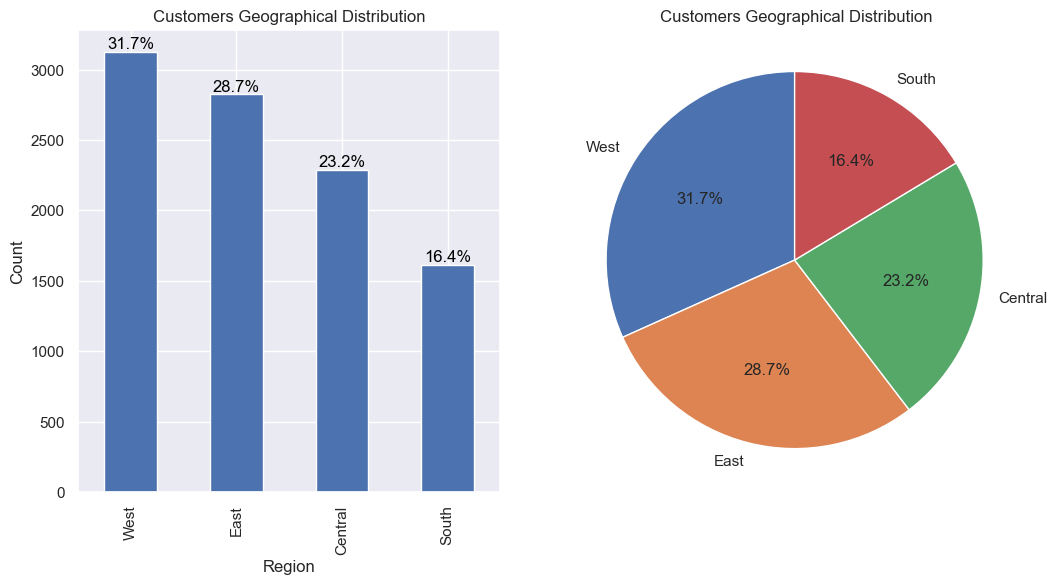

In [61]:
region_counts = geography['Region'].value_counts()

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

region_counts.sort_values(ascending=False).plot(kind='bar', ax=ax[0])

total = abs(region_counts.sum())
for i, value in enumerate(region_counts):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')

ax[0].set_title('Customers Geographical Distribution')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Count')

ax[1].pie(region_counts, labels=region_counts.index, autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Customers Geographical Distribution')

plt.show()

- Our customers are well distributed around the country, with roughly 32%(majority) coming from the western region and around 16%(minority) from the south

##  Average Sales by Region

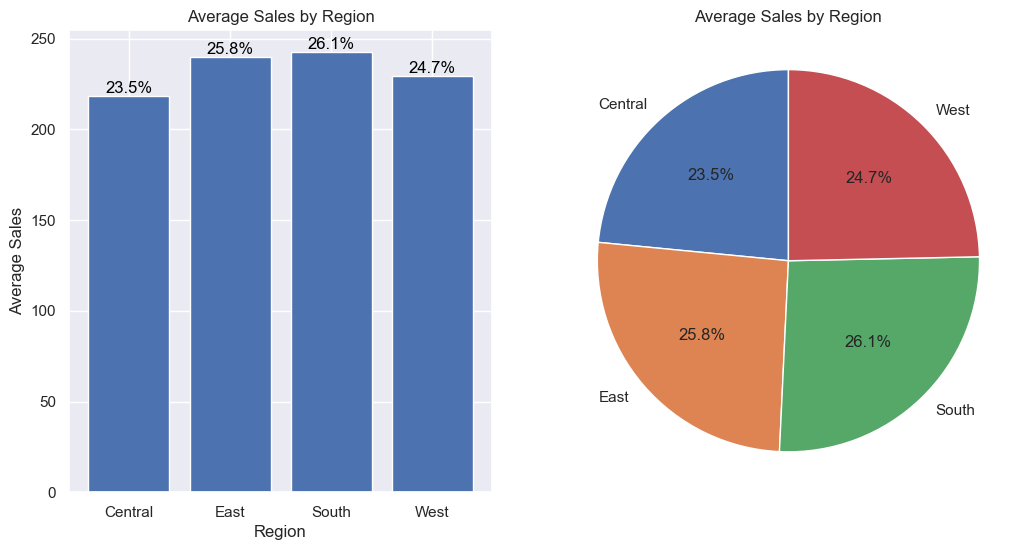

In [60]:
avg_sales_regional = geography.groupby('Region')['Sales'].mean().reset_index(name='Average Sales')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_sales_regional['Region'], avg_sales_regional['Average Sales'])

total = abs(avg_sales_regional['Average Sales'].sum())
for i, value in enumerate(avg_sales_regional['Average Sales']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')
    
ax[0].set_title('Average Sales by Region')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Average Sales')

ax[1].pie(avg_sales_regional['Average Sales'], labels=avg_sales_regional['Region'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Sales by Region')

plt.show()

- Sales around the country looks good, as we make approximately 25% sales in all four regions of the country

## Average Profit by Region

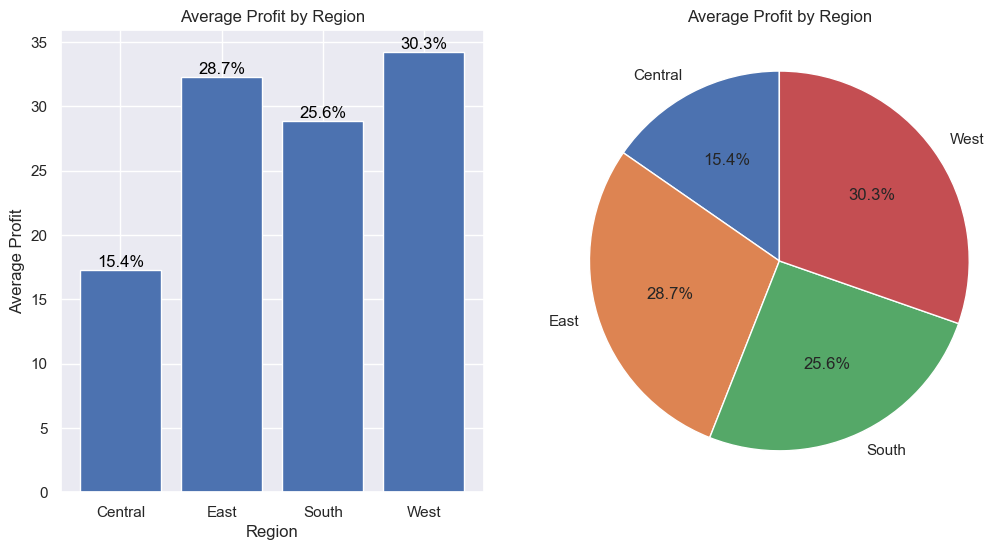

In [59]:
avg_profit_regional = geography.groupby('Region')['Profit'].mean().reset_index(name='Average Profit')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_profit_regional['Region'], avg_profit_regional['Average Profit'])

total = abs(avg_profit_regional['Average Profit'].sum())
for i, value in enumerate(avg_profit_regional['Average Profit']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')
    
ax[0].set_title('Average Profit by Region')
ax[0].set_xlabel('Region')
ax[0].set_ylabel('Average Profit')

ax[1].pie(avg_profit_regional['Average Profit'], labels=avg_profit_regional['Region'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Profit by Region')

plt.show()

- As expected from the rate of sales around the country, our profits are not quite different, with profits of about 25%, 29% and 30% from the South, East and West respectively.


- Central region of the country recorded the lowest profits(15%)

## Average Sales and Profit by Segment 

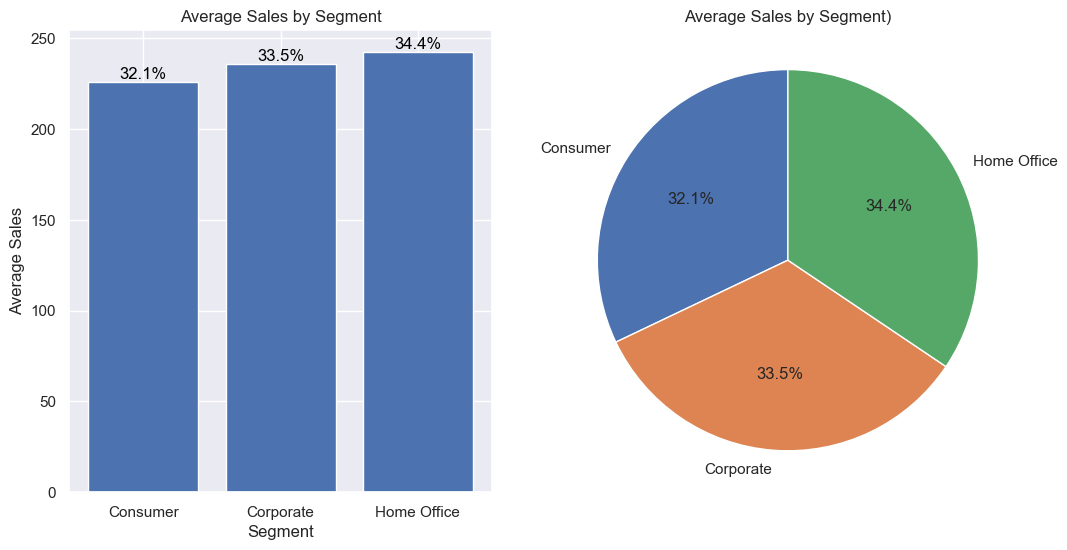

In [58]:
avg_sales_segment = geography.groupby('Segment')['Sales'].mean().reset_index(name='Average Sales')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_sales_segment['Segment'], avg_sales_segment['Average Sales'])

total = abs(avg_sales_segment['Average Sales'].sum())
for i, value in enumerate(avg_sales_segment['Average Sales']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')
    
ax[0].set_title('Average Sales by Segment')
ax[0].set_xlabel('Segment')
ax[0].set_ylabel('Average Sales')

ax[1].pie(avg_sales_segment['Average Sales'], labels=avg_sales_segment['Segment'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Sales by Segment)')

plt.show()

- For each segment we recorded approximately 33% sales

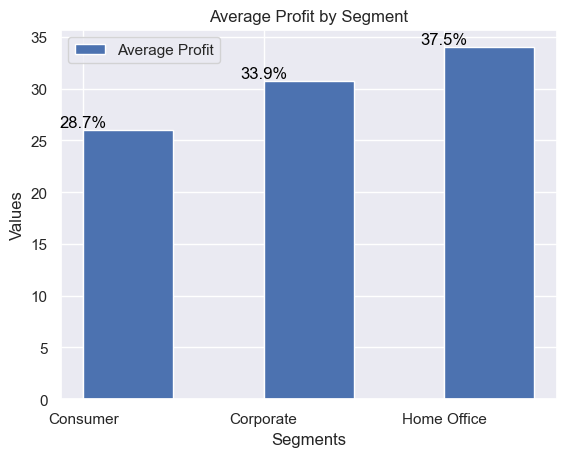

In [62]:
avg_profit_segment = geography.groupby('Segment')['Profit'].mean()

plt.bar(avg_profit_segment.index, avg_profit_segment.values, align='edge', width=0.5, label='Average Profit')

total = abs(avg_profit_segment.sum())
for i, value in enumerate(avg_profit_segment):
    percentage = abs(value) / total * 100
    plt.text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')

plt.xlabel('Segments')
plt.ylabel('Values')
plt.title('Average Profit by Segment')
plt.legend()
plt.show()

- We recorded approximately 28.7%, 33.9% and 37.5% in profits for Consumer, Corporate and Home office respectively

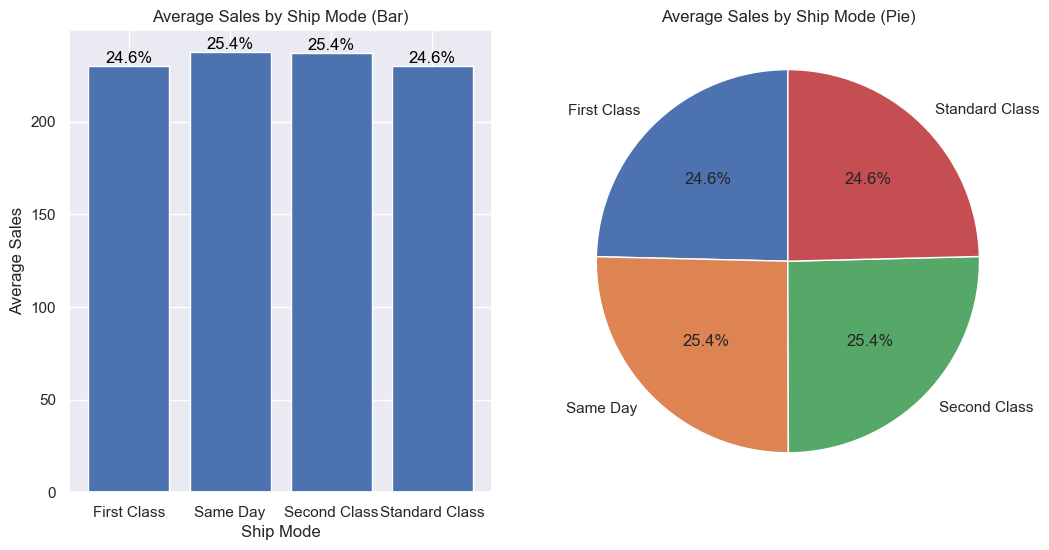

In [19]:
avg_sales_ship = geography.groupby('Ship Mode')['Sales'].mean().reset_index(name='Average Sales')

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].bar(avg_sales_ship['Ship Mode'], avg_sales_ship['Average Sales'])

total = abs(avg_sales_ship['Average Sales'].sum())
for i, value in enumerate(avg_sales_ship['Average Sales']):
    percentage = abs(value) / total * 100
    ax[0].text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')
    
ax[0].set_title('Average Sales by Ship Mode (Bar)')
ax[0].set_xlabel('Ship Mode')
ax[0].set_ylabel('Average Sales')

ax[1].pie(avg_sales_ship['Average Sales'], labels=avg_sales_ship['Ship Mode'], autopct='%1.1f%%', startangle=90)
ax[1].axis('equal')
ax[1].set_title('Average Sales by Ship Mode (Pie)')

plt.show()

- On average, about 25% of our products are sold around the country via each mode of shipment

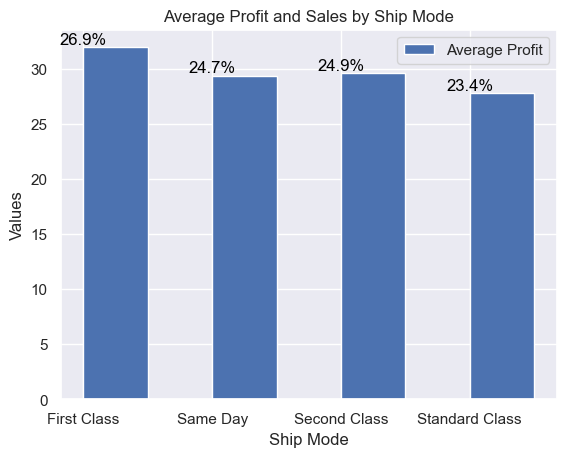

In [57]:
avg_profit_ship = geography.groupby('Ship Mode')['Profit'].mean()

plt.bar(avg_profit_ship.index, avg_profit_ship.values, align='edge', width=0.5, label='Average Profit')

total = abs(avg_profit_ship.sum())
for i, value in enumerate(avg_profit_ship):
    percentage = abs(value) / total * 100
    plt.text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black')
    
plt.xlabel('Ship Mode')
plt.ylabel('Values')
plt.title('Average Profit and Sales by Ship Mode')
plt.legend()
plt.show()

- we recorded an average of about 25% in profit for each mode of shipment

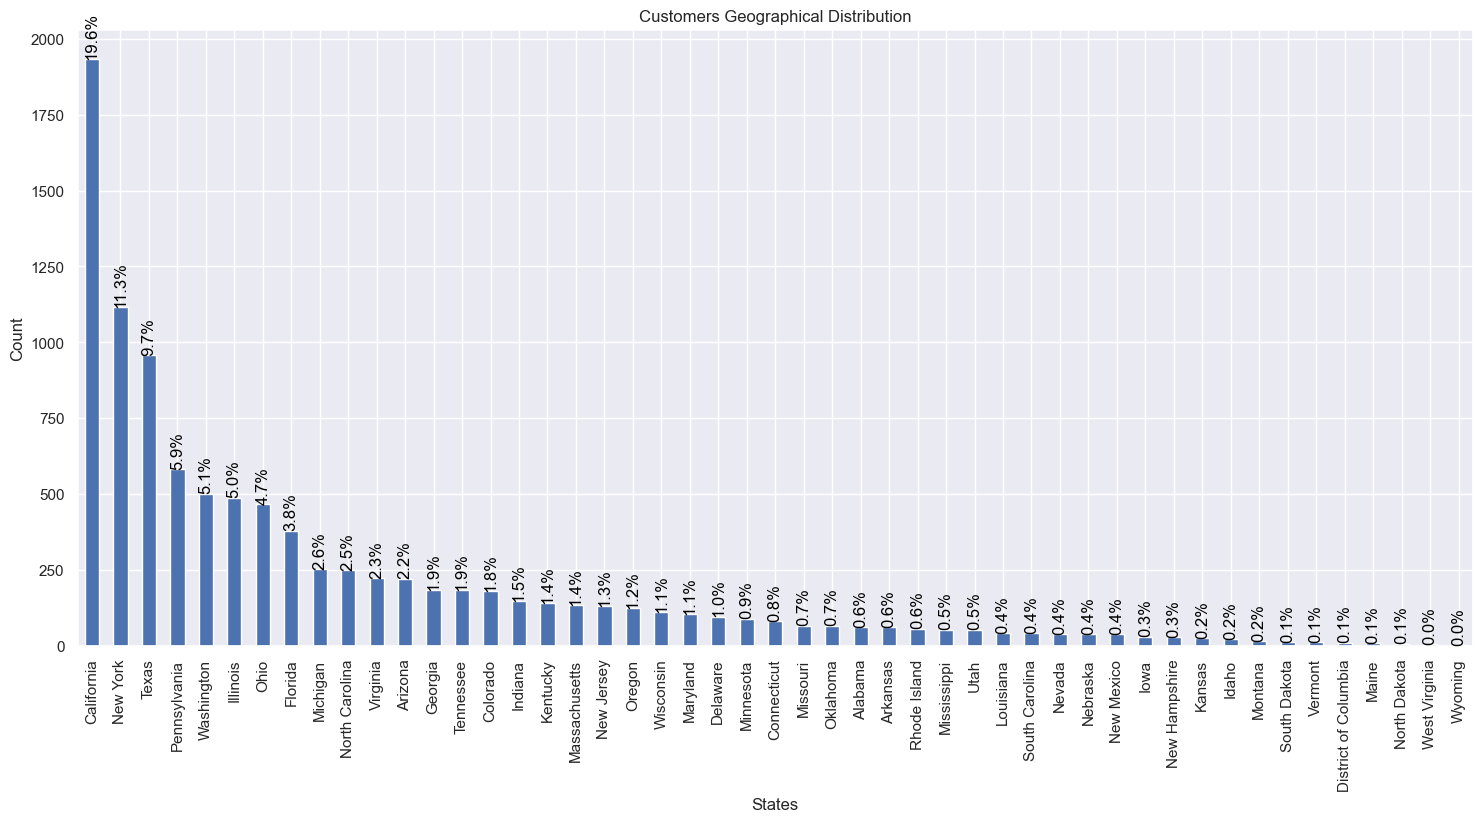

In [22]:
plt.figure(figsize=(18,8))
geography['State'].value_counts().plot(kind='bar')

total = abs(geography['State'].value_counts().sum())
for i, value in enumerate(geography['State'].value_counts()):
    percentage = abs(value) / total * 100
    plt.text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black', rotation=90)


plt.title('Customers Geographical Distribution')
plt.xlabel('States')
plt.ylabel('Count')
plt.show()

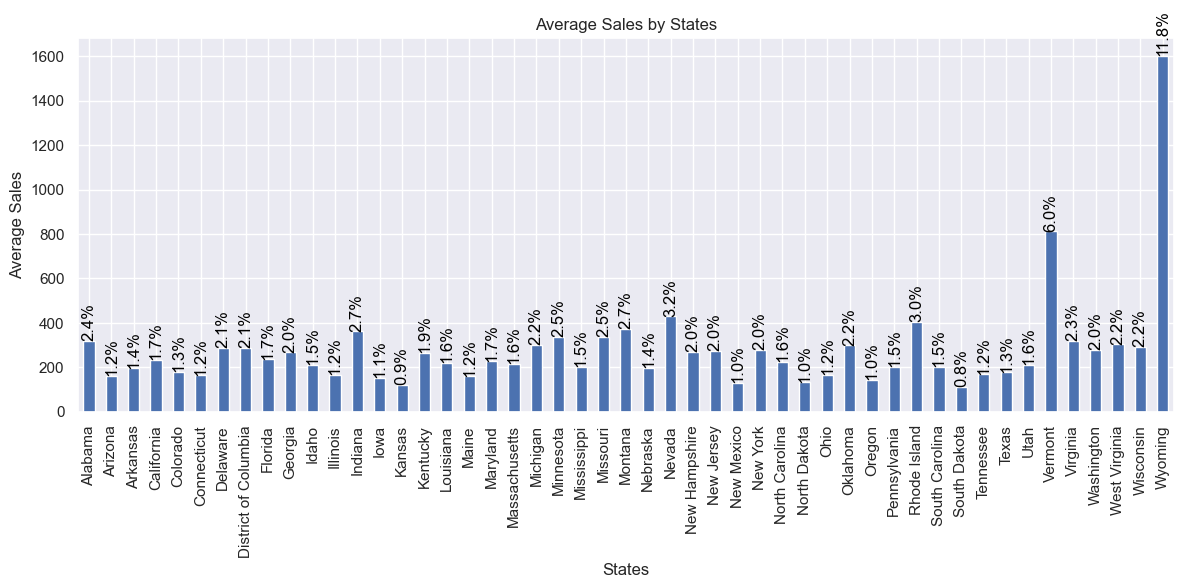

In [23]:
plt.figure(figsize=(12,6))
avg_sales_states = geography.groupby('State')['Sales'].mean()

avg_sales_states.plot(kind='bar')

total = abs(avg_sales_states.sum())
for i, value in enumerate(avg_sales_states):
    percentage = abs(value) / total * 100
    plt.text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black', rotation=90)

plt.title('Average Sales by States')
plt.xlabel('States')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

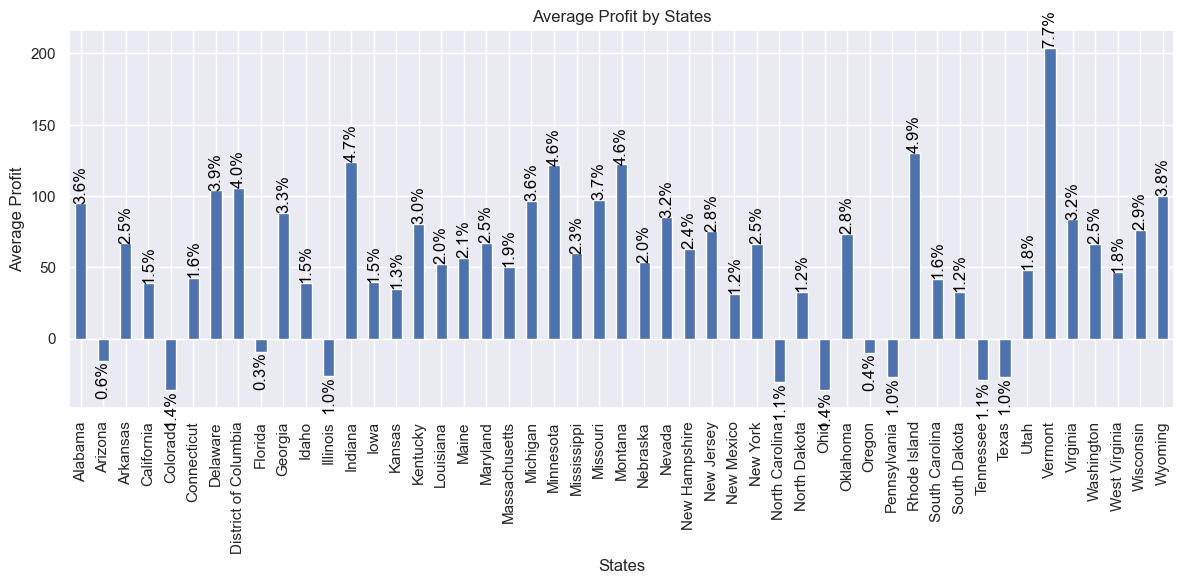

In [24]:
plt.figure(figsize=(12,6))
avg_profit_state = geography.groupby('State')['Profit'].mean()

avg_profit_state.plot(kind='bar')

total = abs(avg_profit_state.sum())
for i, value in enumerate(avg_profit_state):
    percentage = abs(value) / total * 100
    plt.text(i, value, f'{percentage:.1f}%', ha='center', va='bottom' if value >= 0 else 'top', color='black', rotation=90)

plt.title('Average Profit by States')
plt.xlabel('States')
plt.ylabel('Average Profit')
plt.tight_layout()
plt.show()

- The store has a strong presence in the Technology category, contributing significantly to both sales and profits. However, there are areas, such as the Furniture category, where losses are observed, potentially due to high discounts.


- Strategies to optimize discounts, particularly in categories and sub-categories with losses, could improve overall profitability.


- Further investigation into the performance of individual states may provide insights into regional variations and guide targeted marketing efforts.


- The store's distribution network is effective, reaching customers across the country. However, continuous monitoring and adjustment of strategies are essential for sustained success.